In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')
print(sys.path)

['/home/hieutt/UniCon_EnetV2_OpenMax/notebooks', '/home/hieutt/miniconda3/envs/torchtf/lib/python39.zip', '/home/hieutt/miniconda3/envs/torchtf/lib/python3.9', '/home/hieutt/miniconda3/envs/torchtf/lib/python3.9/lib-dynload', '', '/home/hieutt/miniconda3/envs/torchtf/lib/python3.9/site-packages', '../']


In [2]:
import os
import torch
import numpy as np
import pickle
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, f1_score, precision_score, recall_score, accuracy_score
from sklearn.manifold import TSNE
import seaborn as sns
from dataset import CANDatasetEnet as CANDataset
from rd_openmax import openmax_predict_rd, extract_class_stats, fit_weibull_rd
from model_init import *
from torchvision import transforms
from torch.utils.data import DataLoader


In [76]:
seed = 1
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
device = torch.device("cuda")

In [95]:
# Configuration
# /home/hieutt/UniCon_EnetV2_OpenMax/save/CAN_TT_models/UniCon/UniCon_CAN_TT_mpncovresnet50_lr_0.05_decay_0.0001_bsz_256_trial_3_cosine_warm

ckpt_path = "../save/CAN_TT_models/UniCon/UniCon_CAN_TT_mpncovresnet50_lr_0.05_decay_0.0001_bsz_128_trial_2_cosine_warm/ckpt_epoch_66.pth"
class_model_path = "../save/CAN_TT_models/UniCon/UniCon_CAN_TT_mpncovresnet50_lr_0.05_decay_0.0001_bsz_128_trial_2_cosine_warm/ckpt_classifier_epoch_51.pth"
weibull_path = ckpt_path.replace("ckpt_epoch_66.pth", "weibull_epoch_66.pkl")

data_train = "../data/set_04/train_01/preprocessed/20_percent/TFRecord_w64_s32/2"
data_close = "../data/set_04/test_01_known_vehicle_known_attack/preprocessed/5_percent/TFRecord_w64_s32/2"
data_open = "../data/set_04/test_03_known_vehicle_unknown_attack/preprocessed/TFRecord_w64_s32/2"

n_classes = 6
batch_size = 128

In [96]:
def change_state_dict(state_dict):
    """
    Because state dict in distributed GPU is different
    """
    new_state_dict = {}
    for k, v in state_dict.items():
        k = k.replace("module.", "")
        new_state_dict[k] = v
    return new_state_dict

In [97]:
from networks.efficient_net_v2 import ConEfficientNetV2, LinearClassifier
from networks.con_mpncovresnet import ConTinyMPNCOVResNet, LinearClassifier as LinearClassifierMPNCOV
model = ConTinyMPNCOVResNet(
    attention='Cov',
    input_size=64,
    feat_dim=128
)
classifier = LinearClassifier(input_dim=8256, num_classes=n_classes)

ckpt = torch.load(ckpt_path, weights_only=False)
state_dict = ckpt['model']
state_dict = change_state_dict(state_dict)
model.load_state_dict(state_dict=state_dict)

ckpt = torch.load(class_model_path, weights_only=False)
state_dict = ckpt['model']
classifier.load_state_dict(state_dict=state_dict)

# 3. Load Weibull models
with open(weibull_path, 'rb') as f:
    weibull_data = pickle.load(f)
class_means_pretrain = weibull_data['class_means']
weibull_models_pretrain = weibull_data['weibull_models']

model.to(device)
classifier.to(device)


LinearClassifier(
  (fc): Linear(in_features=8256, out_features=6, bias=True)
)

In [98]:
# Load datasets
from util import AddGaussianNoise

mean = (0.5, 0.5, 0.5)
std = (0.5, 0.5, 0.5)
transform = transforms.Compose([
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
train_transform = transforms.Compose([
    transforms.RandomApply([AddGaussianNoise(0., 0.05)], p=0.5),
    transforms.RandomErasing(p=0.3, scale=(0.02, 0.15)),
    transforms.Normalize(mean=mean, std=std)
])

train_set = CANDataset(root_dir=data_train, window_size=32, is_train=True, transform=train_transform)
close_set = CANDataset(root_dir=data_close, window_size=32, is_train=False, transform=transform)
open_set = CANDataset(root_dir=data_open, window_size=32, is_train=False, transform=transform)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
close_loader = torch.utils.data.DataLoader(close_set, batch_size=batch_size, shuffle=False)
open_loader = torch.utils.data.DataLoader(open_set, batch_size=batch_size, shuffle=False)

In [78]:
class_feats, class_means = extract_class_stats(model, classifier, train_loader, device='cuda:0')
weibull_models = fit_weibull_rd(class_feats, class_means, tailsize=50)

In [99]:
total_preds = []
total_labels = []
unk_probs = []
model.eval()
if classifier is not None:
    classifier.eval()

with torch.no_grad():
    for images, labels in open_loader:
        if isinstance(images, (list, tuple)):
            images = images[0]

        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        # 🧠 Feature embedding
        feats = model.encoder(images) if classifier is not None else model(images)
        feats = F.normalize(feats, dim=1)
        feats_np = feats.cpu().numpy()

        for f, label in zip(feats_np, labels.cpu().numpy()):
            
            # pred_class, unk_prob = openmax_predict_rd(f, class_means, weibull_models)
            pred_class, unk_prob = openmax_predict_rd(f, class_means_pretrain, weibull_models_pretrain)
            total_preds.append((pred_class, unk_prob))
            total_labels.append(label)
            unk_probs.append(unk_prob)



In [100]:
best_thresh = 0.7262  # Threshold for unknown class prediction
# 🔁 Ground-truth mapping: only label 0 is known
mapped_label = [0 if l == 0 else 1 for l in total_labels]

# 🔍 Prediction using OpenMax unknown probability
mapped_pred = [0 if p[1] < best_thresh else 1 for p in total_preds]

In [101]:
# 📊 Evaluation
acc = accuracy_score(mapped_label, mapped_pred) * 100
f1 = f1_score(mapped_label, mapped_pred, average='binary')
precision = precision_score(mapped_label, mapped_pred, average='binary', zero_division=0)
recall = recall_score(mapped_label, mapped_pred, average='binary')
conf_matrix = confusion_matrix(mapped_label, mapped_pred)

print(f"Open Set Acc: {acc:.2f}")
print(f"Open Set F1: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

Open Set Acc: 96.15
Open Set F1: 0.8224
Precision: 0.9542
Recall: 0.7225
Confusion Matrix:
[[37362   183]
 [ 1465  3815]]


In [88]:
def plot_confusion_matrix(preds, targets):
    cm = confusion_matrix(targets, preds)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Known', 'Unknown'], yticklabels=['Known', 'Unknown'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix (Open-set)')
    plt.show()



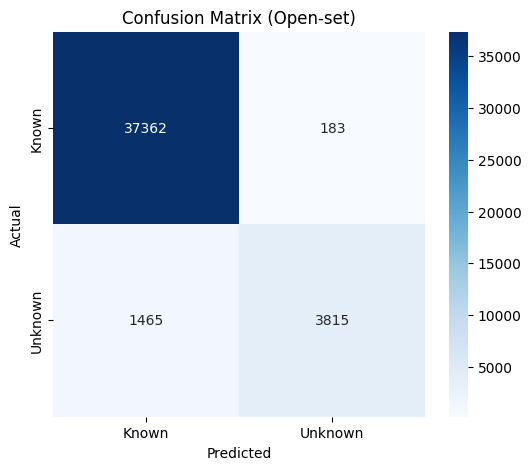

In [102]:
plot_confusion_matrix(mapped_pred, mapped_label)

In [134]:
import pandas as pd
def plot_violin(unk_probs, targets):
    df = pd.DataFrame({
        'Unknown Probability': unk_probs,
        # 'Class': ['Unknown' if t == 1 else 'Known' for t in targets]
        'Class': ['Known' if t == 0 else 'Unknown' for t in targets]
    })

    plt.figure(figsize=(8, 6))
    sns.violinplot(x='Class', y='Unknown Probability', data=df, hue='Class', palette='Set2', legend=False)
    plt.title('Distribution of Unknown Probabilities')
    plt.show()



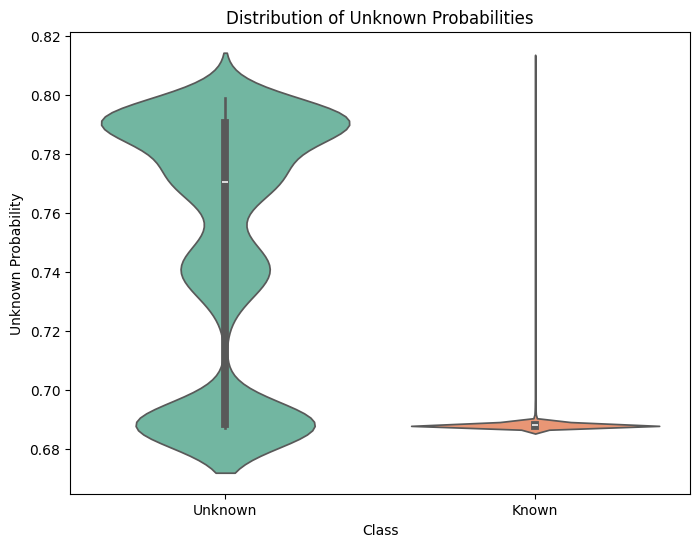

In [135]:
plot_violin(unk_probs, mapped_label)

In [104]:
def plot_roc_curve(pred_probs, targets):
    fpr, tpr, thresholds = roc_curve(targets, pred_probs)
    auc = roc_auc_score(targets, pred_probs)
    plt.figure(figsize=(7, 5))
    plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
    plt.plot([0, 1], [0, 1], '--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - Open-set Detection')
    plt.legend()
    plt.grid(True)
    plt.show()



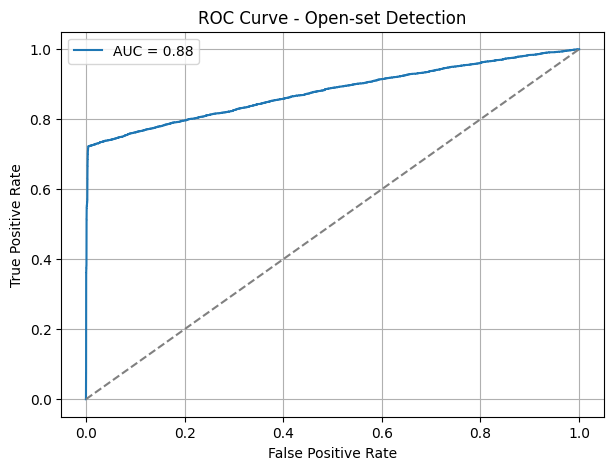

In [105]:
plot_roc_curve([p[1] for p in total_preds], mapped_label)